In [141]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from nltk import pos_tag, word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Project Infomation :-

https://www.kaggle.com/competitions/feedback-prize-effectiveness/overview

Data is NLP based and with two different text columns 

   1- text     
   2- type for text
  
We have essay_id, and a essay_id having multiple text. 

its classification project 

Next Step :

 1- Understand count for each feature and understand distribution of catagorical feature. 
 
 2- understand distribution of dependent feature 

In [196]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [197]:
df.head(3)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate


In [198]:
print("Essay count is ",len(df.essay_id.unique()))
print("Avergare para count in essay",len(df)/len(df.essay_id.unique()))
print("Essay count is ",len(test.essay_id.unique()))
print("Avergare para count in essay",len(df)/len(test.essay_id.unique()))

Essay count is  4191
Avergare para count in essay 8.772369362920545
Essay count is  1
Avergare para count in essay 36765.0


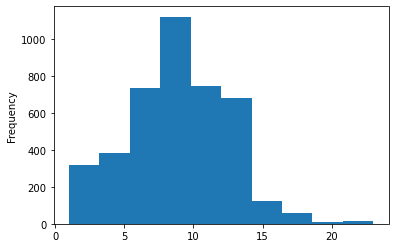

In [5]:
# Distribution of count of paragraph
df.groupby('essay_id')['essay_id'].count().plot(kind = 'hist')
plt.show()

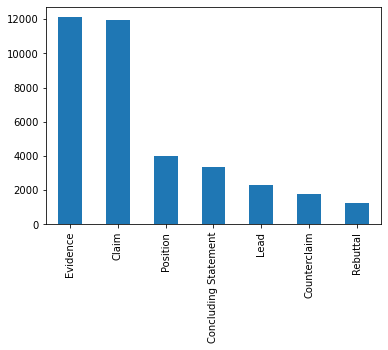

In [6]:
#distribution of discourse_type
df.discourse_type.value_counts().plot(kind = 'bar')
plt.show()


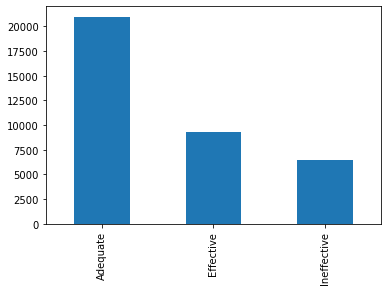

In [184]:
#distribution of discourse effectiveness
df.discourse_effectiveness.value_counts().plot(kind = 'bar')
plt.show()

In [194]:
20000/df.shape[0]

0.5439956480348157

Observation:
    
    1- Essay count is 4191, Average paragraph count in a essay is 8. Max count is 23 and minimum is 1. 
    2- discourse_type having 7 different value and Evidence and claim is taking around 65% of data. 
    3- discourse_effectiveness having three different value. Data is imbalance. Adequate is taking around 54% of data.
    
    
Next Step:
    
    1- Understand duplicates value. 
    
    

# Duplicate values

In [8]:
print("unique text",len(df.discourse_text.unique()))
print('and total observation is ',df.shape[0])
print("duplicate value is", df.shape[0] - len(df.discourse_text.unique()))

unique text 36691
and total observation is  36765
duplicate value is 74


In [9]:
pd.DataFrame(df[df.discourse_text.duplicated(keep = False)][['discourse_text','discourse_effectiveness']].value_counts())

,,0
discourse_text,discourse_effectiveness,
Summer projects should be student-designed,Adequate,14
Summer projects should be teacher-designed,Adequate,7
The electoral college is unfair to voters.,Adequate,5
Students would benefit from being able to attend classes from home,Adequate,4
The advantages of limiting car usage,Ineffective,3
I think we should keep the Electoral College,Adequate,3
Seeking multiple opinions can help someone make a better choice,Adequate,3
big states,Ineffective,3
These summer projects should be student-designed,Adequate,3


In [10]:
df[df.discourse_text =='big states ']

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
26475,20aa9f3e2ed5,A3D23CFB2043,big states,Claim,Ineffective
29447,be69b963a136,CB09A5442145,big states,Claim,Ineffective
31230,6a53b002c7ae,E6FDA0489273,big states,Claim,Ineffective


In [11]:
df[df.discourse_text =='Big States ']

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
20121,35bf70c4a673,4CA37D113612,Big States,Claim,Ineffective
28436,9e12ec699196,BB3A6C2D0B65,Big States,Claim,Adequate


Observation :
    
    1 - There is 74 duplicate value,some value is repeated in around 7 essay. 
    
    2- There is some duplicate value with different label we need to clean these. 
    
Next step:
    
    1- we need to understant that should be keep duplicate values or should work on remvoving these. 
    2- Understand how my discourse_type is associated with dataset
    

In [12]:
tmp = pd.DataFrame(df.groupby('essay_id')['discourse_type'].value_counts())
tmp.columns = ['amount']
tmp.reset_index(drop = False,inplace = True)
tmp = tmp.pivot_table(index = 'essay_id',columns = 'discourse_type').amount
tmp.fillna(0,inplace=True)

In [13]:
tmp

discourse_type,Claim,Concluding Statement,Counterclaim,Evidence,Lead,Position,Rebuttal
essay_id,,,,,,,
00066EA9880D,3.0,1.0,0.0,3.0,1.0,1.0,0.0
000E6DE9E817,5.0,1.0,1.0,3.0,0.0,1.0,1.0
0016926B079C,7.0,0.0,0.0,3.0,0.0,1.0,0.0
00203C45FC55,1.0,1.0,3.0,3.0,1.0,1.0,3.0
0029F4D19C3F,2.0,1.0,1.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
FFA381E58FC6,2.0,1.0,0.0,1.0,0.0,1.0,0.0
FFC43F453EF6,4.0,1.0,3.0,1.0,0.0,1.0,1.0
FFD97A99CEBA,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [14]:
tmp_2 = df.groupby('essay_id')['discourse_effectiveness'].value_counts().to_frame()
tmp_2.columns = ['amount']
tmp_2.reset_index(inplace = True)
tmp_2 = tmp_2.pivot_table(index='essay_id',columns='discourse_effectiveness').amount
tmp_2.fillna(0,inplace =True)

In [15]:
tmp_2

discourse_effectiveness,Adequate,Effective,Ineffective
essay_id,,,
00066EA9880D,2.0,7.0,0.0
000E6DE9E817,10.0,0.0,2.0
0016926B079C,10.0,0.0,1.0
00203C45FC55,3.0,10.0,0.0
0029F4D19C3F,7.0,1.0,1.0
...,...,...,...
FFA381E58FC6,3.0,0.0,2.0
FFC43F453EF6,9.0,1.0,1.0
FFD97A99CEBA,0.0,0.0,1.0


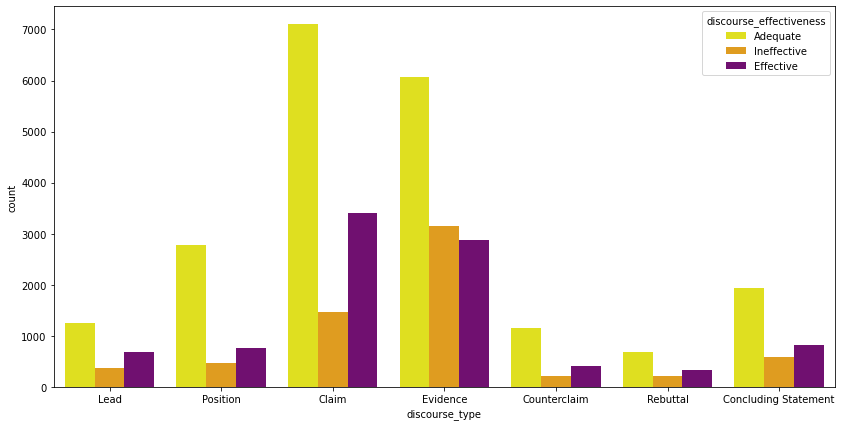

In [16]:
plt.figure(figsize = (14,7))
sns.countplot(x = df.discourse_type, hue = df.discourse_effectiveness,palette=['yellow','orange','purple'])
plt.show()

Observation:

     1- Claim and Evidence having higher stack of Adequate and effective. 
     2- Position having higher stack for Adequate. 

Next step:

    1- Understand length of para
    2- word count in dataset. 
    3- Most common word in dataset. 
    

# Understanding length of paragraph 

In [17]:
df['para_length']=df.discourse_text.apply(lambda x : len(x.split(' ')))

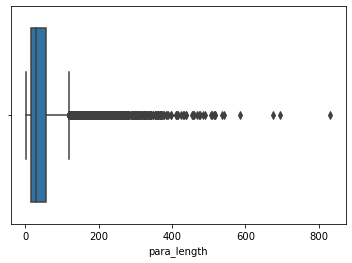

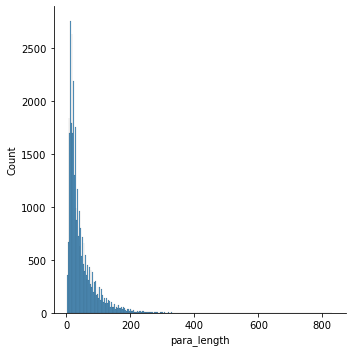

In [18]:
sns.boxplot(x = df.para_length)
plt.show()
sns.displot(x = df.para_length)
plt.show()

In [19]:
dict_count ={}
for j in tqdm(df.discourse_text.to_list()):
    for i in j.split(' '):
        if i in dict_count:
            dict_count[i] = dict_count[i]+1
        else:
            dict_count[i] = 1

100%|██████████| 36765/36765 [00:00<00:00, 39816.73it/s]


In [20]:
sort_dict = sorted(dict_count.items(),key = lambda x : x[1],reverse = True)

In [21]:
print("There is {} unique word in dataset".format(len(sort_dict)))

There is 57915 unique word in dataset


In [201]:
sort_dict[0:5]

[('the', 77029), ('to', 57099), ('', 40924), ('a', 37948), ('and', 36473)]

In [23]:
def get_pos_tags(x):
    tokens=word_tokenize(x)
    tags = pos_tag(tokens,tagset='universal')
    return Counter( tag for word,  tag in tags)

In [26]:
df['Pos_tag'] = df.discourse_text.apply(lambda x: get_pos_tags(x))

In [37]:
df = pd.concat([df,df.Pos_tag.apply(pd.Series).fillna(0)], axis =1).drop('Pos_tag',axis =1)

# Observation :

    1- Average sentance length(word in a paragraph) is around 200, max value is going untill 800. 
    2- There is 57915  unique word in given dataset. 
    3- As expected 'the','to','.', 'a','an' is highly used word in dataset. 
    4 -Positional tagging can be usefule to uderstand if my label is assoicated with these values

Next Step :
    
    1- Go with base line model with tensorflow and LSTM approach

In [43]:
pos_col = ['NOUN', '.', 'VERB', 'PRT',
       'ADP', 'ADV', 'DET', 'ADJ', 'CONJ', 'PRON', 'NUM', 'X']

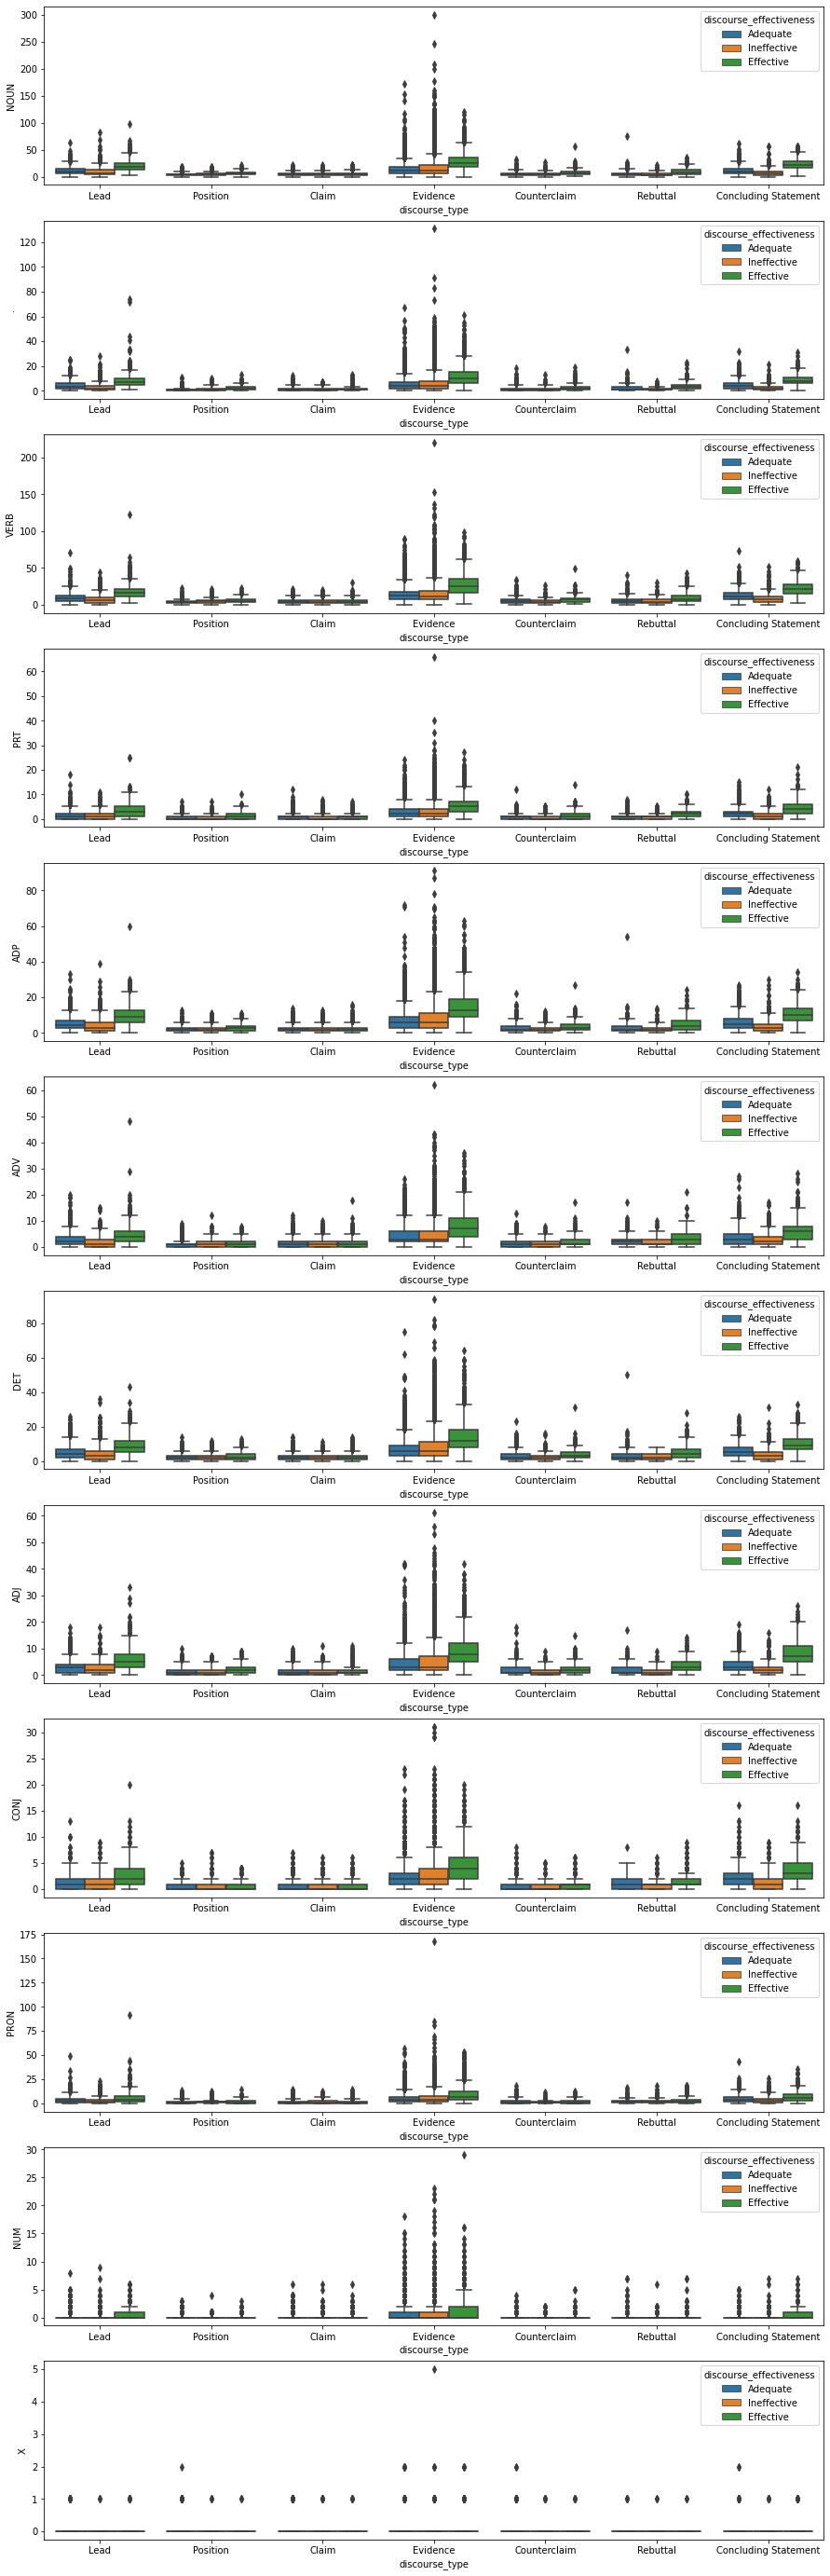

In [47]:
plt.subplots(12,1,figsize = (15,50))
n = 1
for i in pos_col:
    plt.subplot(12,1,n)
    sns.boxplot(data = df, x = 'discourse_type', y = i,hue='discourse_effectiveness')
    n = n+1

# Model Building

In [98]:
max_word = 50000
output_dim = 156
output_length = 200
batch_size = 16

In [99]:
df =pd.read_csv('train.csv')

In [174]:
text = df['discourse_type'] +"  CLS " + df['discourse_text']
text = text.to_list()
y = df.discourse_effectiveness

one = OneHotEncoder(sparse=False)
y = one.fit_transform(y.values.reshape(-1, 1))


X_train, X_test, y_train, y_test = train_test_split(text, y, test_size=0.20, random_state=42)
train = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [176]:
tokenizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=max_word, 
                                                                         output_sequence_length=output_length)
tokenizer.adapt(X_train)

In [177]:
embed = tf.keras.layers.Embedding(input_dim = max_word,output_dim=output_dim)

In [178]:
inputs= tf.keras.layers.Input(shape = (1,), dtype=tf.string)
tokens = tokenizer(inputs)
embedding = embed(tokens)
layer_1,_,_ = tf.keras.layers.LSTM(units = 10,return_sequences=True,return_state=True,activation='relu')(embedding)
layer_2,_,_ = tf.keras.layers.LSTM(units = 10,return_sequences=True,return_state=True,
                                   activation='relu')(layer_1)
layer_3,_,_ = tf.keras.layers.LSTM(units=10,activation='relu',return_sequences=True,return_state=True)(layer_2)
flatten = tf.keras.layers.Flatten()(layer_3)
output = tf.keras.layers.Dense(3,activation = 'softmax')(flatten)

(None, 1)
(None, 200)
(None, 200, 156)
(None, 200, 10)
(None, 200, 10)
(None, 2000)
(None, 3)


In [179]:
model = tf.keras.Model(inputs,output)

In [180]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [182]:
history = model.fit(train,validation_data=test,epochs=2)

Epoch 1/2
1839/1839 [==============================] - 512s 278ms/step - loss: 0.7256 - accuracy: 0.6805 - val_loss: 0.7738 - val_accuracy: 0.6580
Epoch 2/2
1839/1839 [==============================] - 546s 297ms/step - loss: 0.6426 - accuracy: 0.7217 - val_loss: 0.8405 - val_accuracy: 0.6391


# Study link


1- Understanding LSTm - 

https://colah.github.io/posts/2015-08-Understanding-LSTMs/
    
2- Tokenization -

https://neptune.ai/blog/tokenization-in-nlp

3- Embedding-
    
https://www.kdnuggets.com/2021/11/guide-word-embedding-techniques-nlp.html
    
https://jalammar.github.io/illustrated-word2vec/

4- optimizer - 

https://ruder.io/optimizing-gradient-descent/
    
5- Loss function 

https://analyticsindiamag.com/ultimate-guide-to-loss-functions-in-tensorflow-keras-api-with-python-implementation/

initially we can focus on MAE,MSE,Catagorical cross entrophy and Sparse catagorial loss function
    
6- Tensorflow data

https://pyimagesearch.com/2021/06/14/a-gentle-introduction-to-tf-data-with-tensorflow/ 
   this example is for image database but can give good understanding on how tf.data API is useful


